# COVID-19 Headlines

[The anonymous web service Top.st](top.st) extracts the contemporary most-shared news. The [social-bot Topstbot](https://botsin.space/topst) promotes the top most headline on the [federated social-media platform Mastodon](https://mastodon.io). Assuming, its feed can be regarded as an archive of top relevant news headlines, how did German media react to the COVID-19 numbers?

In [1]:
from scrape import entorb

delay_from_infection_to_symptom = 4 # RKI
delay_from_symptom_to_death = 13

cases = entorb.to_dataframe('DE-total')

In [2]:
cases_new = cases['Cases_New'].resample('7D').mean()
high_cases_new = cases_new[(cases_new.shift(1) < cases_new) & (cases_new.shift(-1) < cases_new)].resample('7D').mean()
low_cases_new = cases_new[(cases_new.shift(1) > cases_new) & (cases_new.shift(-1) > cases_new)].resample('7D').mean()

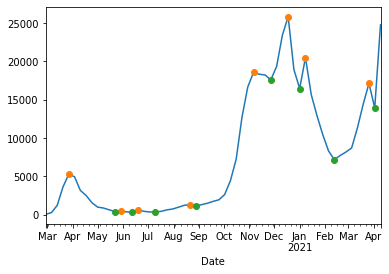

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
fig, ax = plt.subplots()
cases_new.plot(kind='line', ax=ax)
high_cases_new.plot(kind='line', linestyle='', marker='o', ax=ax)
low_cases_new.plot(kind='line', linestyle='', marker='o', ax=ax)
fig.set_facecolor('w')

In [14]:
from scrape import topstbot

nation = 'de'
headlines = topstbot.to_dataframe(since='2020-03-01T00:00:00.000Z', tagged=['week', nation])

#headlines['content'] = [fromstring(h).text_content() for h in headlines['content']]
headlines['date'] = headlines.index.normalize().tz_localize(None)
headlines['text'] = [x.split("\t")[0] for x in headlines['content']]
#headlines['url'] = [x.split("\t")[1].replace('#news #day #de', '') for x in headlines['content']]
headlines = headlines \
.reset_index() \
.set_index('date') \
.drop(columns=['text']) \

In [ ]:
# high cases
pd.set_option('display.max_colwidth', 100)
display(headlines \
        .loc[headlines.index.intersection(high_cases_new.index).drop_duplicates()] \
        .set_index('created_at'))

# Frankfurter Allgemeine Zeitung

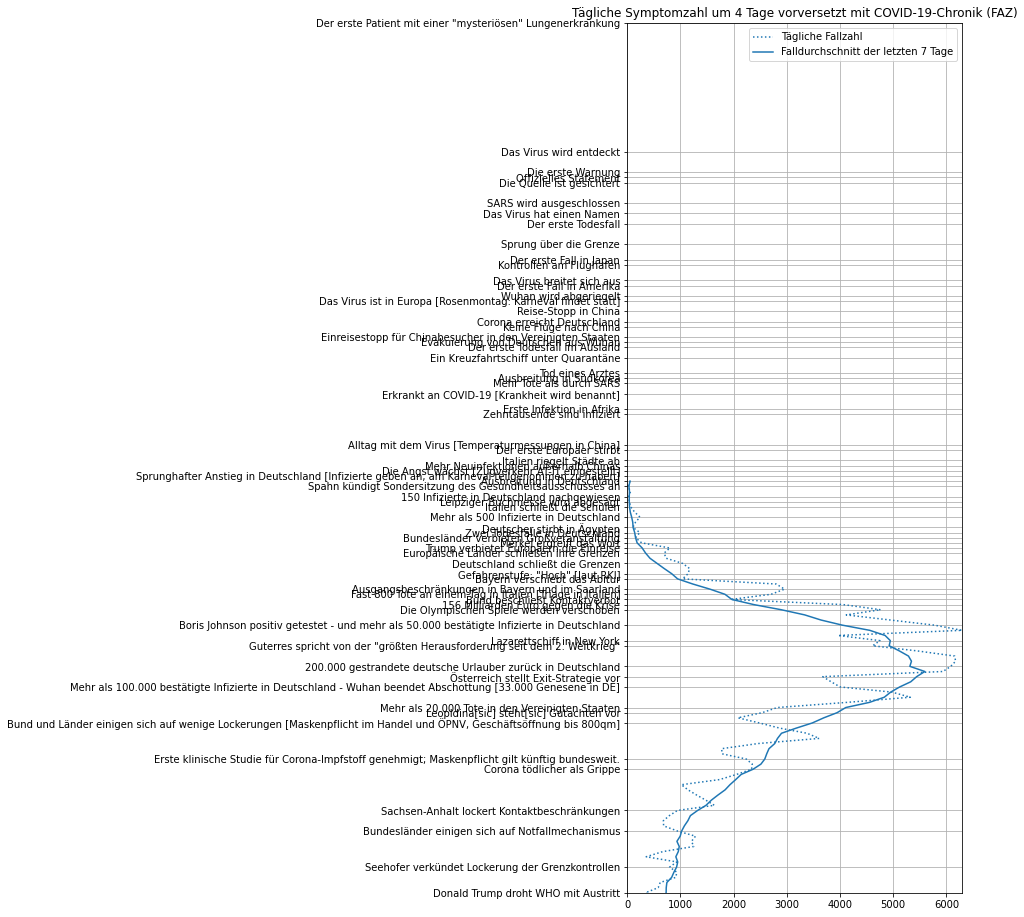

In [28]:
news = pd.read_csv('data/chronic_de.tsv', sep="\t", usecols=['Datum', 'Ereignis'])
news['Datum'] = pd.to_datetime(news['Datum'], format='%Y-%m-%d')
news = news.set_index('Datum')

dt = delay_from_infection_to_symptom #+ delay_from_symptom_to_death
shifted = cases['Cases_New'].shift(-0)

fig, ax = plt.subplots()
ax.plot(shifted,
        shifted.index, 
        linestyle=':',
        label='Tägliche Fallzahl')
ax.plot(shifted.rolling('7D').mean(),
        shifted.index,
        color=ax.lines[0].get_color(),
        label='Falldurchschnitt der letzten 7 Tage')
ax.set_title("Tägliche Symptomzahl um %d Tage vorversetzt mit COVID-19-Chronik (FAZ)" % dt)
ax.set_yticks(news.index)
ax.set_ylim((news.index.max(), news.index.min()))
ax.set_yticklabels(news['Ereignis'])
ax.set_xlim(0,shifted.head(90).max())
ax.grid()
fig.set_size_inches(6,16)
fig.set_facecolor('w')
plt.legend(loc='upper right')
t = ax.set_ylabel('')